# IMPORTS

In [93]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go

In [94]:
comics = pd.read_csv("TodosComics.csv", index_col=0)
characters = pd.read_csv("TodosPersonagens.csv", index_col=0)
creators = pd.read_csv("TodosCreators.csv", index_col=0)
events = pd.read_csv("TodosEvents.csv", index_col=0)

# INSIGHTS

In [95]:
characters

,id,name,description,modified,resourceURI,urls,thumbnail.path,thumbnail.extension,comics.available,comics.collectionURI,...,series.items,series.returned,stories.available,stories.collectionURI,stories.items,stories.returned,events.available,events.collectionURI,events.items,events.returned
0,1011334,3-D Man,NaN,2014-04-29T14:18:17+0000,https://gateway.marvel.com/v1/public/character...,"[{'type': 'detail', 'url': 'http://marvel.com/...",http://i.annihil.us/u/prod/marvel/i/mg/c/e0/53...,jpg,12,https://gateway.marvel.com/v1/public/character...,...,[{'resourceURI': 'https://gateway.marvel.com/v...,3,21,https://gateway.marvel.com/v1/public/character...,[{'resourceURI': 'https://gateway.marvel.com/v...,20,1,https://gateway.marvel.com/v1/public/character...,[{'resourceURI': 'https://gateway.marvel.com/v...,1
1,1017100,A-Bomb (HAS),Rick Jones has been Hulk's best bud since day ...,2013-09-18T15:54:04+0000,https://gateway.marvel.com/v1/public/character...,"[{'type': 'detail', 'url': 'http://marvel.com/...",http://i.annihil.us/u/prod/marvel/i/mg/3/20/52...,jpg,4,https://gateway.marvel.com/v1/public/character...,...,[{'resourceURI': 'https://gateway.marvel.com/v...,2,7,https://gateway.marvel.com/v1/public/character...,[{'resourceURI': 'https://gateway.marvel.com/v...,7,0,https://gateway.marvel.com/v1/public/character...,[],0
2,1009144,A.I.M.,AIM is a terrorist organization bent on destro...,2013-10-17T14:41:30+0000,https://gateway.marvel.com/v1/public/character...,"[{'type': 'detail', 'url': 'http://marvel.com/...",http://i.annihil.us/u/prod/marvel/i/mg/6/20/52...,jpg,53,https://gateway.marvel.com/v1/public/character...,...,[{'resourceURI': 'https://gateway.marvel.com/v...,20,61,https://gateway.marvel.com/v1/public/character...,[{'resourceURI': 'https://gateway.marvel.com/v...,20,0,https://gateway.marvel.com/v1/public/character...,[],0
3,1010699,Aaron Stack,NaN,1970-01-01T00:00:00+0000,https://gateway.marvel.com/v1/public/character...,"[{'type': 'detail', 'url': 'http://marvel.com/...",http://i.annihil.us/u/prod/marvel/i/mg/b/40/im...,jpg,14,https://gateway.marvel.com/v1/public/character...,...,[{'resourceURI': 'https://gateway.marvel.com/v...,3,28,https://gateway.marvel.com/v1/public/character...,[{'resourceURI': 'https://gateway.marvel.com/v...,20,0,https://gateway.marvel.com/v1/public/character...,[],0
4,1009146,Abomination (Emil Blonsky),"Formerly known as Emil Blonsky, a spy of Sovie...",2014-06-27T19:39:07+0000,https://gateway.marvel.com/v1/public/character...,"[{'type': 'detail', 'url': 'http://marvel.com/...",http://i.annihil.us/u/prod/marvel/i/mg/9/50/4c...,jpg,55,https://gateway.marvel.com/v1/public/character...,...,[{'resourceURI': 'https://gateway.marvel.com/v...,20,68,https://gateway.marvel.com/v1/public/character...,[{'resourceURI': 'https://gateway.marvel.com/v...,20,1,https://gateway.marvel.com/v1/public/character...,[{'resourceURI': 'https://gateway.marvel.com/v...,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1559,1011515,Zeus,Zeus ruled a peaceful Olympus for centuries wh...,2021-08-18T22:06:56+0000,https://gateway.marvel.com/v1/public/character...,"[{'type': 'detail', 'url': 'http://marvel.com/...",http://i.annihil.us/u/prod/marvel/i/mg/f/60/4c...,png,36,https://gateway.marvel.com/v1/public/character...,...,[{'resourceURI': 'https://gateway.marvel.com/v...,13,43,https://gateway.marvel.com/v1/public/character...,[{'resourceURI': 'https://gateway.marvel.com/v...,20,0,https://gateway.marvel.com/v1/public/character...,[],0
1560,1011127,Zodiak,"Twelve demons merged with Norman Harrison, who...",1970-01-01T00:00:00+0000,https://gateway.marvel.com/v1/public/character...,"[{'type': 'detail', 'url': 'http://marvel.com/...",http://i.annihil.us/u/prod/marvel/i/mg/b/40/im...,jpg,1,https://gateway.marvel.com/v1/public/character...,...,[{'resourceURI': 'https://gateway.marvel.com/v...,1,1,https://gateway.marvel.com/v1/public/character...,[{'resourceURI': 'https://gateway.marvel.com/v...,1

In [96]:
comics

,id,digitalId,title,issueNumber,variantDescription,description,modified,isbn,upc,diamondCode,...,characters.items,characters.returned,stories.available,stories.collectionURI,stories.items,stories.returned,events.available,events.collectionURI,events.items,events.returned
0,82967,0,Marvel Previews (2017),0.0,NaN,NaN,2019-11-07T08:46:15+0000,NaN,75960608839302811,NaN,...,[],0,2,https://gateway.marvel.com/v1/public/comics/82...,[{'resourceURI': 'https://gateway.marvel.com/v...,2,0,https://gateway.marvel.com/v1/public/comics/82...,[],0
1,82965,0,Marvel Previews (2017),0.0,NaN,NaN,2019-08-21T17:11:27+0000,NaN,75960608839302611,JUL190068,...,[],0,2,https://gateway.marvel.com/v1/public/comics/82...,[{'resourceURI': 'https://gateway.marvel.com/v...,2,0,https://gateway.marvel.com/v1/public/comics/82...,[],0
2,82970,52952,Marvel Previews (2017),0.0,NaN,NaN,2020-02-07T09:35:32+0000,NaN,75960608839303111,NaN,...,[],0,2,https://gateway.marvel.com/v1/public/comics/82...,[{'resourceURI': 'https://gateway.marvel.com/v...,2,0,https://gateway.marvel.com/v1/public/comics/82...,[],0
3,61137,0,The Punisher (2016) #5 (Cosplay Variant),5.0,Cosplay Variant,NaN,2016-09-01T12:40:16+0000,NaN,75960608413500521,NaN,...,[],0,2,https://gateway.marvel.com/v1/public/comics/61...,[{'resourceURI': 'https://gateway.marvel.com/v...,2,0,https://gateway.marvel.com/v1/public/comics/61...,[],0
4,37497,0,MARVELS (1994) #1,1.0,NaN,NaN,2014-05-08T12:18:55+0000,NaN,NaN,NaN,...,[],0,0,https://gateway.marvel.com/v1/public/comics/37...,[],0,0,https://gateway.marvel.com/v1/public/comics/37...,[],0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64263,21671,0,Psi-Force (1986) #28,28.0,NaN,NaN,-0001-11-30T00:00:00+0000,NaN,NaN,NaN,...,[],0,2,https://gateway.marvel.com/v1/public/comics/21...,[{'resourceURI': 'https://gateway.marvel.com/v...,2,0,https://gateway.marvel.com/v1/public/comics/21...,[],0
64264,21672,0,Psi-Force (1986) #29,29.0,NaN,NaN,-0001-11-30T00:00:00+0000,NaN,NaN,NaN,...,[],0,2,https://gateway.marvel.com/v1/public/comics/21...,[{'resourceURI': 'https://gateway.marvel.com/v...,2,0,https://gateway.marvel.com/v1/public/comics/21...,[],0
64265,21674,0,Psi-Force (1986) #30,30.0,NaN,NaN,-0001-11-30T00:00:00+0000,NaN,NaN,NaN,...,[],0,2,https://gateway.marvel.com/v1/public/comics/21...,[{'resourceURI': 'https://gateway.marvel.com/v...,2,0,https://gateway.marvel.com/v1/public/comics/21...,[],0
64266,21675,0,Psi-Force (1986) #31,31.0,NaN,NaN,-0001-11-30T00:00:00+0000,NaN,NaN,NaN,...,[],0,2,https://gateway.marvel.com/v1/public/comics/21...,[{'resourceURI': 'https://gateway.marvel.com/v...,2,0,https://gateway.marvel.com/v1/public/comics/21...,[],0


## Colunas NaN

In [97]:
Nan_relation = {}
for col in comics.columns:
  Nan_relation[col] = comics[col].isna().sum()

df = pd.DataFrame(list(Nan_relation.items()), columns=['Colunas', 'Quantidade'])
df = df[df["Quantidade"] > 0]

fig = px.bar(df, x='Colunas', y='Quantidade',
             color="Colunas",
             template="presentation",
             labels={'Colunas': 'Colunas', 'Quantidade': 'Frequência de Nulos'},
             title="Quantidade de valores nulos por coluna em Comics")

fig.update_layout(xaxis_tickangle=-45)
fig.show()

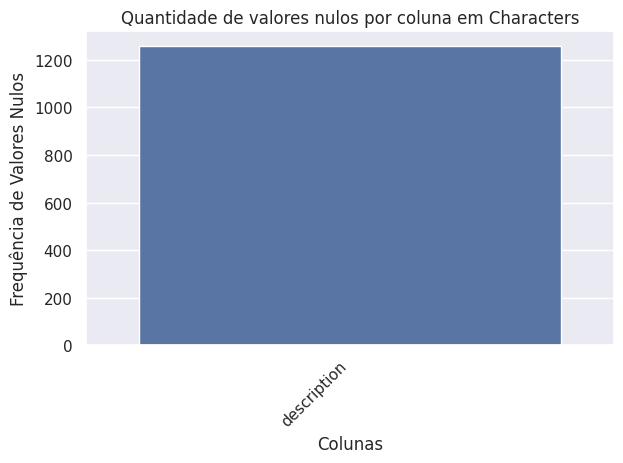

In [98]:
Nan_relation = {}
for col in characters.columns:
  Nan_relation[col] = characters[col].isna().sum()

df = pd.DataFrame(list(Nan_relation.items()), columns=['Colunas', 'Quantidade'])
df = df[df["Quantidade"] > 0]

sns.set_theme()
sns.barplot(data=df, x="Colunas", y="Quantidade")
plt.xlabel("Colunas")
plt.ylabel("Frequência de Valores Nulos")
plt.title("Quantidade de valores nulos por coluna em Characters")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


In [99]:
characters["last_modified"] = characters["modified"].str.split('-').str[0]
personagens_modificados = characters["last_modified"].value_counts().reset_index()
personagens_modificados.columns = ["Ano", "Quantidade"]

media_pessimista = abs(personagens_modificados["Quantidade"].mean() - personagens_modificados["Quantidade"].std())

personagens_modificados[personagens_modificados["Quantidade"] > media_pessimista]

fig = px.bar(personagens_modificados, x='Ano', y='Quantidade',
             color="Ano",
             template="presentation",
             labels={'Colunas': 'Ano de Modificação', 'Quantidade': 'Quantidade de Modificações'},
             title="Quantidade de modificações por ano em Characters")

fig.update_layout(xaxis_tickangle=-45)
fig.show()

In [100]:
comics["last_modified"] = comics["modified"].str.split('-').str[0]
comics_modificados = comics["last_modified"].value_counts().reset_index()
comics_modificados.columns = ["Ano", "Quantidade"]

media = abs(comics_modificados["Quantidade"].mean())

comics_modificados[comics_modificados["Quantidade"] > media]

fig = px.bar(comics_modificados, x='Ano', y='Quantidade',
             color="Ano",
             template="presentation",
             labels={'Colunas': 'Ano de Modificação', 'Quantidade': 'Quantidade de Modificações'},
             title="Quantidade de modificações por ano em Comics")

fig.update_layout(xaxis_tickangle=-45)
fig.show()

## PERSONAGENS COM APARIÇÃO ACIMA DA MÉDIA

In [101]:
most_comics_characters = characters[characters["comics.available"] > characters["comics.available"].mean()]

In [102]:
media_de_aparicao = characters["comics.available"].mean()

In [103]:
print(f"Existem {len(most_comics_characters)} personagens, com aparições acima da média (acima de {int(media_de_aparicao)} aparições)")

Existem 280 personagens, com aparições acima da média (acima de 65 aparições)


In [104]:
print("Personagens que mais aparecem")
most_comics_characters[["name", "description", "comics.available", "stories.available",  "events.available"]].sort_values("comics.available", ascending=False).head(10).reset_index(drop=True)

Personagens que mais aparecem


,name,description,comics.available,stories.available,events.available
0,Spider-Man (Peter Parker),"Bitten by a radioactive spider, high school st...",4533,6588,37
1,X-Men,Feared and hated by humans because they're dif...,4113,5820,43
2,Wolverine,Born with super-human senses and the power to ...,2761,3811,44
3,Iron Man,"Wounded, captured and forced to build a weapon...",2745,4098,31
4,Captain America,"Vowing to serve his country any way he could, ...",2545,3723,30
5,Avengers,Earth's Mightiest Heroes joined forces to take...,2298,3129,32
6,Thor,"As the Norse God of thunder and lightning, Tho...",1903,2827,27
7,Hulk,Caught in a gamma bomb explosion while trying ...,1777,2710,26
8,Fantastic Four,"After being exposed to cosmic rays, Reed Richa...",1564,2437,24
9,Daredevil,"Abandoned by his mother, Matt Murdock was rais...",1286,1994,17


In [105]:
print("Personagens que menos aparecem")
most_comics_characters[["name", "description", "comics.available", "stories.available",  "events.available"]].sort_values("comics.available", ascending=True).head(10).reset_index(drop=True)

Personagens que menos aparecem


,name,description,comics.available,stories.available,events.available
0,Spider-Man (Ben Reilly),NaN,66,68,1
1,Penance (Robert Baldwin),NaN,66,84,6
2,Omega Red,NaN,66,76,1
3,Spider-Ham (Larval Earth),As Spider-Ham Peter faced such nefarious foes ...,67,68,0
4,Fantomex,NaN,67,74,4
5,Dum Dum Dugan,NaN,67,84,3
6,Storm (Ultimate),"Ororo Munroe was raised in Morocco, learning E...",67,122,0
7,Cyclops (Ultimate),NaN,67,121,0
8,Iceman (Ultimate),NaN,67,118,0
9,Annihilus,NaN,67,85,1


In [106]:
nao_possuem_desc = len(most_comics_characters[most_comics_characters["description"].isna()])
possuem_desc = len(most_comics_characters[~most_comics_characters["description"].isna()])

print(f"A quantidade de personagens que têm a descrição nula é: {nao_possuem_desc}")
print(f"A quantidade de personagens que não têm a descrição nula é: {possuem_desc}")

A quantidade de personagens que têm a descrição nula é: 205
A quantidade de personagens que não têm a descrição nula é: 75


In [107]:
most_comics_characters["Has_Desc"] = most_comics_characters["description"].apply(lambda x: 0 if pd.isna(x) else 1)

<ipython-input-107-a5472f3b1012>:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



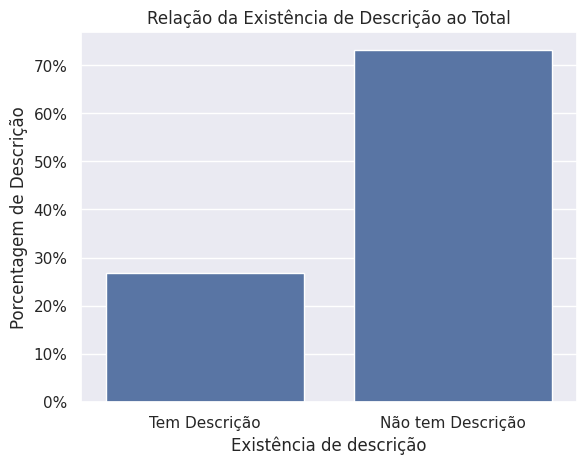

In [108]:
sns.barplot(x=["Tem Descrição", "Não tem Descrição"], y=[(possuem_desc/len(most_comics_characters))*100, (nao_possuem_desc/len(most_comics_characters))*100])
plt.xlabel("Existência de descrição")
plt.ylabel("Porcentagem de Descrição")
plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda y, _: f'{y:.0f}%'))
plt.title("Relação da Existência de Descrição ao Total")
plt.show()

In [109]:
corr_cols = round(float(most_comics_characters["Has_Desc"].corr(most_comics_characters["comics.available"])),2)
print(f"A correlação entre ter descrição e a quantidade de quadrinhos disponíveis deste personagem é de {corr_cols}")

A correlação entre ter descrição e a quantidade de quadrinhos disponíveis deste personagem é de 0.27


In [110]:
comics

,id,digitalId,title,issueNumber,variantDescription,description,modified,isbn,upc,diamondCode,...,characters.returned,stories.available,stories.collectionURI,stories.items,stories.returned,events.available,events.collectionURI,events.items,events.returned,last_modified
0,82967,0,Marvel Previews (2017),0.0,NaN,NaN,2019-11-07T08:46:15+0000,NaN,75960608839302811,NaN,...,0,2,https://gateway.marvel.com/v1/public/comics/82...,[{'resourceURI': 'https://gateway.marvel.com/v...,2,0,https://gateway.marvel.com/v1/public/comics/82...,[],0,2019
1,82965,0,Marvel Previews (2017),0.0,NaN,NaN,2019-08-21T17:11:27+0000,NaN,75960608839302611,JUL190068,...,0,2,https://gateway.marvel.com/v1/public/comics/82...,[{'resourceURI': 'https://gateway.marvel.com/v...,2,0,https://gateway.marvel.com/v1/public/comics/82...,[],0,2019
2,82970,52952,Marvel Previews (2017),0.0,NaN,NaN,2020-02-07T09:35:32+0000,NaN,75960608839303111,NaN,...,0,2,https://gateway.marvel.com/v1/public/comics/82...,[{'resourceURI': 'https://gateway.marvel.com/v...,2,0,https://gateway.marvel.com/v1/public/comics/82...,[],0,2020
3,61137,0,The Punisher (2016) #5 (Cosplay Variant),5.0,Cosplay Variant,NaN,2016-09-01T12:40:16+0000,NaN,75960608413500521,NaN,...,0,2,https://gateway.marvel.com/v1/public/comics/61...,[{'resourceURI': 'https://gateway.marvel.com/v...,2,0,https://gateway.marvel.com/v1/public/comics/61...,[],0,2016
4,37497,0,MARVELS (1994) #1,1.0,NaN,NaN,2014-05-08T12:18:55+0000,NaN,NaN,NaN,...,0,0,https://gateway.marvel.com/v1/public/comics/37...,[],0,0,https://gateway.marvel.com/v1/public/comics/37...,[],0,2014
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64263,21671,0,Psi-Force (1986) #28,28.0,NaN,NaN,-0001-11-30T00:00:00+0000,NaN,NaN,NaN,...,0,2,https://gateway.marvel.com/v1/public/comics/21...,[{'resourceURI': 'https://gateway.marvel.com/v...,2,0,https://gateway.marvel.com/v1/public/comics/21...,[],0,
64264,21672,0,Psi-Force (1986) #29,29.0,NaN,NaN,-0001-11-30T00:00:00+0000,NaN,NaN,NaN,...,0,2,https://gateway.marvel.com/v1/public/comics/21...,[{'resourceURI': 'https://gateway.marvel.com/v...,2,0,https://gateway.marvel.com/v1/public/comics/21...,[],0,
64265,21674,0,Psi-Force (1986) #30,30.0,NaN,NaN,-0001-11-30T00:00:00+0000,NaN,NaN,NaN,...,0,2,https://gateway.marvel.com/v1/public/comics/21...,[{'resourceURI': 'https://gateway.marvel.com/v...,2,0,https://gateway.marvel.com/v1/public/comics/21...,[],0,
64266,21675,0,Psi-Force (1986) #31,31.0,NaN,NaN,-0001-11-30T00:00:00+0000,NaN,NaN,NaN,...,0,2,https://gateway.marvel.com/v1/public/comics/21...,[{'resourceURI': 'https://gateway.marvel.com/v...,2,0,https://gateway.marvel.com/v1/public/comics/21...,[],0,


In [111]:
creators = creators[~creators["fullName"].isna()]

In [112]:
cols = ["fullName", "events.available", "stories.available"]
most_events = creators[cols].sort_values("events.available", ascending=False).head(100)
most_events

,fullName,events.available,stories.available
855,Vc Joe Caramagna,29,12553
1261,Frank D'ARMATA,21,2680
1993,Scott Hanna,21,2051
3326,Tom Palmer,19,1176
1578,Vc Chris Eliopoulos,19,2435
...,...,...,...
670,Dan Brown,7,536
2546,Daniel Ketchum,7,958
2242,Jeffrey Huet,7,108
2545,Rick Ketcham,7,114


In [113]:
cols = ["fullName", "stories.available", "events.available"]
most_stories = creators[cols].sort_values("stories.available", ascending=False).head(100)
most_stories

,fullName,stories.available,events.available
4778,Jeff Youngquist,17934,8
855,Vc Joe Caramagna,12553,29
626,Tom Brevoort,9907,13
3341,Mark Paniccia,8917,10
1189,Vc Clayton Cowles,8910,11
...,...,...,...
2522,Joe Kelly,754,2
3829,Valerio Schiti,750,0
1094,Vince Colletta,748,1
1451,Terry Dodson,746,9


In [114]:
events

,id,title,description,resourceURI,urls,modified,start,end,thumbnail.path,thumbnail.extension,...,series.available,series.collectionURI,series.items,series.returned,next.resourceURI,next.name,previous.resourceURI,previous.name,next,previous
0,116,Acts of Vengeance!,Loki sets about convincing the super-villains ...,https://gateway.marvel.com/v1/public/events/116,"[{'type': 'detail', 'url': 'http://marvel.com/...",2013-06-28T16:31:24+0000,1989-12-10 00:00:00,2008-01-04 00:00:00,http://i.annihil.us/u/prod/marvel/i/mg/9/40/51...,jpg,...,21,https://gateway.marvel.com/v1/public/events/11...,[{'resourceURI': 'https://gateway.marvel.com/v...,20,https://gateway.marvel.com/v1/public/events/240,Days of Future Present,https://gateway.marvel.com/v1/public/events/233,Atlantis Attacks,NaN,NaN
1,227,Age of Apocalypse,"In a twisted version of the world they knew, t...",https://gateway.marvel.com/v1/public/events/227,"[{'type': 'detail', 'url': 'http://marvel.com/...",2016-08-01T11:34:39+0000,1995-03-01 00:00:00,1996-06-01 00:00:00,http://i.annihil.us/u/prod/marvel/i/mg/5/e0/51...,jpg,...,20,https://gateway.marvel.com/v1/public/events/22...,[{'resourceURI': 'https://gateway.marvel.com/v...,20,https://gateway.marvel.com/v1/public/events/239,Crossing,https://gateway.marvel.com/v1/public/events/219,Siege of Darkness,NaN,NaN
2,314,Age of Ultron,In a 10-issue event written by Brian Michael B...,https://gateway.marvel.com/v1/public/events/314,"[{'type': 'detail', 'url': 'http://marvel.com/...",2016-11-07T15:05:02+0000,2013-03-06 00:00:00,2013-06-19 00:00:00,http://i.annihil.us/u/prod/marvel/i/mg/c/10/51...,jpg,...,7,https://gateway.marvel.com/v1/public/events/31...,[{'resourceURI': 'https://gateway.marvel.com/v...,7,https://gateway.marvel.com/v1/public/events/315,Infinity,https://gateway.marvel.com/v1/public/events/311,Marvel NOW!,NaN,NaN
3,303,Age of X,In a strange reality where the X-Men never cam...,https://gateway.marvel.com/v1/public/events/303,"[{'type': 'detail', 'url': 'http://marvel.com/...",2013-06-28T18:34:27+0000,2011-01-26 00:00:00,2011-05-01 00:00:00,http://i.annihil.us/u/prod/marvel/i/mg/5/40/51...,jpg,...,4,https://gateway.marvel.com/v1/public/events/30...,[{'resourceURI': 'https://gateway.marvel.com/v...,4,https://gateway.marvel.com/v1/public/events/302,Fear Itself,https://gateway.marvel.com/v1/public/events/296,Chaos War,NaN,NaN
4,329,All-New All-Different Marvel,"This fall, prepare for an all-new, all-differe...",https://gateway.marvel.com/v1/public/events/329,"[{'type': 'detail', 'url': 'http://marvel.com/...",2016-08-01T11:34:33+0000,NaN,NaN,http://i.annihil.us/u/prod/marvel/i/mg/b/f0/55...,jpg,...,0,https://gateway.marvel.com/v1/public/events/32...,[],0,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68,316,X-Men: Battle of the Atom,The presence of the original X-Men in the mode...,https://gateway.marvel.com/v1/public/events/316,"[{'type': 'detail', 'url': 'http://marvel.com/...",2015-01-08T16:51:58+0000,2013-09-04 00:00:00,2013-10-31 00:01:00,http://i.annihil.us/u/prod/marvel/i/mg/a/50/51...,jpg,...,5,https://gateway.marvel.com/v1/public/events/31...,[{'resourceURI': 'https://gateway.marvel.com/v...,5,https://gateway.marvel.com/v1/public/events/317,Inhumanity,https://gateway.marvel.com/v1/public/events/315,Infinity,NaN,NaN
69,308,X-Men: Regenesis,"In the aftermath of X-Men: Schism, the Childre...",https://gateway.marvel.com/v1/public/events/308,"[{'type': 'detail', 'url': 'http://marvel.com/...",2013-08-19T16:17:57+0000,2011-10-12 00:00:00,2012-04-25 00:00:00,http://i.annihil.us/u/prod/marvel/i/mg/6/30/52...,jpg,...,8,https://gateway.marvel.com/v1/public/events/30...,[{'resourceURI': 'https://gateway.marvel.com/v...,8,https://gateway.marvel.com/v1/public/events/309,Shattered Heroes,https://gateway.marvel.com/v1/public/events/305,Spider-Island,NaN,NaN
70,306,X-Men: Schism,A new Hellfire Club unleashes Sentinels on Uto...,https://gateway.marvel.com/v1/public/events/30

In [115]:
#stories